## Importations

In [3]:
%matplotlib widget

import pandas as pd

import numpy as np
import matplotlib.pyplot as axs
import seaborn as sns


from matplotlib import animation
from scipy.signal import correlate

import matplotlib.pyplot as plt

from math import * 
from sklearn.preprocessing import normalize
import numpy.ma as ma


plt.rcParams['animation.ffmpeg_path'] = '/ffmpeg_python'


## Clean .csv


In [4]:
def col_gen_for_csv(target_cols):
    r = ['R','P','Y','x','y','z']
    print(',,',end='')
    for c in target_cols:
        for dim in r:
            print(dim+str(c), end=',')


col_gen_for_csv(['base',4,7])



,,Rbase,Pbase,Ybase,xbase,ybase,zbase,R4,P4,Y4,x4,y4,z4,R7,P7,Y7,x7,y7,z7,

In [5]:
N_SENSORS = 7
MOCAP_SAMPLING_HZ = 100
points = [4,7]
my_axis = ['x','y','z']

## Load data
- Load files from .csv
- scale time

Output:
- datasets of IMU data and motion capture data

In [6]:
def read_ros_file(file, points, MOCAP_SAMPLING_HZ):
    # Define the column's names
    cols_names = {"time":"time"}
    for sensor in points: 
        cols_names[".x"+str(sensor)]="x"+str(sensor)
        cols_names[".y"+str(sensor)]="y"+str(sensor) 
        cols_names[".z"+str(sensor)]="z"+str(sensor)
    
    # Read the right values
    df = pd.read_csv(file, usecols=cols_names.keys())
    df = df.rename(cols_names, axis=1)

    # Standardize unit on mm
    df[df.columns.drop('time')] = 1000*df[df.columns.drop('time')]

    # Standardize time series
    df["time"]= pd.to_datetime(df["time"])
    df["time_sync"]= pd.Series().astype(int)


    offset = df.time.loc[0]
    for instant in df.time.index:
        df.time.loc[instant] = (df.time.loc[instant]- offset)
        df.time.loc[instant] = int(df["time"].loc[instant].microseconds*1E-3 + 1E3*(df["time"].loc[instant].seconds))
        df['time_sync'].loc[instant] = round(df.time.loc[instant]/(1E3/MOCAP_SAMPLING_HZ))*(1E3/MOCAP_SAMPLING_HZ )
    df.time_sync = df.time_sync.astype(int)
    return df

        
def interpolate_ros_file(df):
    df_out = df.copy()
    for col in df.drop(columns=['time','time_sync']).columns:
        df_out[col].loc[0] = df[col].loc[0]
        for line in range(1,len(df)):
            y1,y2,x1,x2 = df[col].loc[line-1],df[col].loc[line],df.time.loc[line-1],df.time.loc[line]
            a = (y2-y1)/(x2-x1)
            df_out[col].loc[line]= y1+a*(df['time'].loc[line] - x1)
    return df_out


In [7]:
df_pcc05_raw = read_ros_file("data/elephant/pcc/pcc05.csv", points, MOCAP_SAMPLING_HZ)
df_pcc05_raw = interpolate_ros_file(df_pcc05_raw)

df_pcc2_raw = read_ros_file("data/elephant/pcc/pcc2.csv", points, MOCAP_SAMPLING_HZ)
df_pcc2_raw = interpolate_ros_file(df_pcc2_raw) 

df_pcc4_raw = read_ros_file("data/elephant/pcc/pcc4.csv", points, MOCAP_SAMPLING_HZ)
df_pcc4_raw = interpolate_ros_file(df_pcc4_raw)

df_pcc6_raw = read_ros_file("data/elephant/pcc/pcc6.csv", points, MOCAP_SAMPLING_HZ)
df_pcc6_raw = interpolate_ros_file(df_pcc6_raw)

df_pcc8_raw = read_ros_file("data/elephant/pcc/pcc8.csv", points, MOCAP_SAMPLING_HZ)
df_pcc8_raw = interpolate_ros_file(df_pcc8_raw)


df_rigid_raw = read_ros_file("data/elephant/rigid/rigid.csv", points, MOCAP_SAMPLING_HZ)
df_rigid_inter = interpolate_ros_file(df_rigid_raw)

df_pcc1_raw = read_ros_file("data/elephant/pcc/pcc1.csv", points, MOCAP_SAMPLING_HZ)
df_pcc1_raw = interpolate_ros_file(df_pcc1_raw)


/home/ros-melodic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/ros-melodic/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [8]:
df_less_imu_2_raw = interpolate_ros_file(read_ros_file("data/fly/less_imu/less_imu_2.csv", points, MOCAP_SAMPLING_HZ))
df_less_imu_4_raw = interpolate_ros_file(read_ros_file("data/fly/less_imu/less_imu_4.csv", points, MOCAP_SAMPLING_HZ))
df_less_imu_8_raw = interpolate_ros_file(read_ros_file("data/fly/less_imu/less_imu_8.csv", points, MOCAP_SAMPLING_HZ))





/home/ros-melodic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
df_pcc16_2_raw = interpolate_ros_file(read_ros_file("data/fly/pcc16/pcc16_2.csv", points, MOCAP_SAMPLING_HZ))
df_pcc16_4_raw = interpolate_ros_file(read_ros_file("data/fly/pcc16/pcc16_4.csv", points, MOCAP_SAMPLING_HZ))
df_pcc16_8_raw = interpolate_ros_file(read_ros_file("data/fly/pcc16/pcc16_8.csv", points, MOCAP_SAMPLING_HZ))

/home/ros-melodic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
def read_mocap(file, MOCAP_SAMPLING_HZ, points, offset):
    cols = []
    for ax in ['x','y','z']:
        cols.append(ax+'base')
        for seg in points:
            cols.append(ax+str(seg))
            
    df = pd.read_csv(file, usecols=cols)

    for ax in ['x','y','z']:
        cols.append(ax+'base')
        for seg in points:
            df[ax+str(seg)] = df[ax+str(seg)]-df[ax+'base']-offset[ax]

    df['time_sync'] = df.index.copy()

    df['time_sync'] = df['time_sync'].apply(lambda x: x*int(1E3/MOCAP_SAMPLING_HZ))
    df = df.drop(columns=['xbase','ybase','zbase'])
    return df

offset_mocap = {'x':0,'y':0,'z':17}

df_mocap_raw = read_mocap("data/dodo/mocap/mocap_base_and_2_points_1.csv", MOCAP_SAMPLING_HZ, points, offset_mocap)


,x4,y4,z4,x7,y7,z7,time_sync
0,203.222885,-187.612747,-98.948669,354.808853,-244.419593,-276.125854,0
1,203.252960,-187.679825,-99.004822,354.816406,-244.417709,-276.109375,10
2,203.235535,-187.672500,-99.000671,354.818451,-244.417823,-276.133606,20
3,203.249267,-187.670197,-99.005371,354.816101,-244.428208,-276.126770,30
4,203.220871,-187.628875,-98.917114,354.805252,-244.415153,-276.107300,40


In [ ]:
def plotter(x,y, df, ax, seg_list):
    axes = ['x','y','z']
    ax[x,y].plot(df[axes[x]+str(seg_list[y])])

## Spacial processing
- switch axes 



In [ ]:
%matplotlib widget 

axes_map_mocap = {'x':'y','y':'x','z':'z'} 
axes_sign_mocap = {'x':1,'y':-1,'z':1} 

axes_map_rigid = {'x':'x','y':'y','z':'z'} #TO EDIT
axes_sign_rigid = {'x':1,'y':1,'z':1} #TO EDIT

# Switch axes
def swich_axes(axes_map, axes_sign, df, cols_to_drop):
    df_copy = pd.DataFrame()
    for col in df.drop(columns=cols_to_drop).columns:
        ax, seg = col[0], col[1]
        df_copy[axes_map[ax]+seg] = df[col]
        df_copy[axes_map[ax]+seg] = df_copy[axes_map[ax]+seg]*axes_sign[ax]
        
        
    df_copy[cols_to_drop] = df[cols_to_drop]
    return df_copy

df_mocap_space = swich_axes(axes_map_mocap, axes_sign_mocap, df_mocap_raw,['time_sync'])
df_rigid_space = swich_axes(axes_map_rigid, axes_sign_rigid, df_rigid_inter,['time_sync','time'])

## Time processing
- Adjust the sampling frequencies
- Use cross-correlation to find the delay between both signals. Remove this delay. Merge each mocap with its corresponding rigid body
- Create ```df_full``` to make easy boxplot 

In [ ]:
# Adjust time sampling frequency
df_mocap_timed = df_mocap_space.merge(df_rigid_raw.time_sync, on='time_sync', how='inner', suffixes=('_rigid','_mocap'))


## Shift time

In [ ]:
IMPOSSIBLE_ERROR = [10000,30000]

def err_wrt_mocap(df_mocap, df_rigid, start_index, stop_index):
    df_err = pd.DataFrame()
    for col in df_mocap.columns:
        df_err[col] = abs(df_mocap[col].loc[start_index:stop_index]-df_rigid[col].loc[start_index:stop_index])
    return df_err

def norm_3D(df_in, axis=['x','y','z']):
    df_out = pd.DataFrame()
    local_list_points = []
    if 'x4' in df_in.columns and 'y4' in df_in.columns and 'z4' in df_in.columns:
        local_list_points.append(4)
    if 'x7' in df_in.columns and 'y7' in df_in.columns and 'z7' in df_in.columns:
        local_list_points.append(7)
    for seg in local_list_points:
        df_out['seg_'+str(seg)] = np.sqrt(sum(df_in[ax+str(seg)]**2 for ax in axis))
        df_out['seg_'+str(seg)] = df_out['seg_'+str(seg)].loc[df_out['seg_'+str(seg)] < IMPOSSIBLE_ERROR[points.index(seg)]]
    return df_out
    
def shift_time(df, shift):
    df_copy = df.copy()
    df_copy = df_copy.loc[shift:]
    df_copy['time_sync'] = df_copy['time_sync'].apply(lambda x: x-df['time_sync'].loc[shift])
    df_copy = df_copy.reset_index()
    return df_copy.drop(columns=['index'])


In [ ]:
shift_mocap = 700
shift_pcc05 = 49
shift_pcc1 = 53
shift_pcc2 = 54
shift_pcc4 = 54
shift_pcc6 = 56
shift_pcc8 = 56
shift_less_imu_2 = 36
shift_less_imu_4 = 38
shift_less_imu_8 = 17
shift_pcc16_2 =  55
shift_pcc16_4 = 51
shift_pcc16_8 = 53

df_mocap_shifted = shift_time(df_mocap_timed, shift_mocap)
df_pcc1_timed = shift_time(df_pcc1_raw, shift_pcc1)
df_pcc2_timed = shift_time(df_pcc2_raw, shift_pcc2)
df_pcc4_timed = shift_time(df_pcc4_raw, shift_pcc4)
df_pcc6_timed = shift_time(df_pcc6_raw, shift_pcc6)
df_pcc8_timed = shift_time(df_pcc8_raw, shift_pcc8)
df_less_imu_2_timed = shift_time(df_less_imu_2_raw, shift_less_imu_2)
df_less_imu_4_timed = shift_time(df_less_imu_4_raw, shift_less_imu_4)
df_less_imu_8_timed = shift_time(df_less_imu_8_raw, shift_less_imu_8)
df_pcc16_2_timed = shift_time(df_pcc16_2_raw, shift_pcc16_2)
df_pcc16_4_timed = shift_time(df_pcc16_4_raw, shift_pcc16_4)
df_pcc16_8_timed = shift_time(df_pcc16_8_raw, shift_pcc16_8)


if 1:
    %matplotlib widget
    fig, axs = plt.subplots(3,2, sharex='all', sharey='all', figsize = (18,7))
    for x in range(3): #axes
        for y in range(len(points)): #segments
            plotter(x,y,df_mocap_shifted, axs, points)
           # plotter(x,y,df_less_imu_2_timed, axs, points)
           # plotter(x,y,df_less_imu_4_timed, axs, points)
           # plotter(x,y,df_less_imu_8_timed, axs, points)
           # plotter(x,y,df_pcc1_timed, axs, points)
           # plotter(x,y,df_pcc2_timed, axs, points)
           # plotter(x,y,df_pcc4_timed, axs, points)
           # plotter(x,y,df_pcc6_timed, axs, points)
           # plotter(x,y,df_pcc8_timed, axs, points) 
            plotter(x,y,df_pcc16_2_timed, axs, points)
            plotter(x,y,df_pcc16_4_timed, axs, points)
            plotter(x,y,df_pcc16_8_timed, axs, points)
            axs[x,y].legend(['mocap','2 imu','4 imu','8 imu','pcc1','pcc2','pcc4','pcc6','pcc8'])
            axs[x,y].set_ylabel(my_axis[x])
            axs[x,y].set_xlabel('point '+str(points[y]))

NameError: name 'shift_time' is not defined

Using matplotlib backend: module://ipympl.backend_nbagg


<AxesSubplot:>

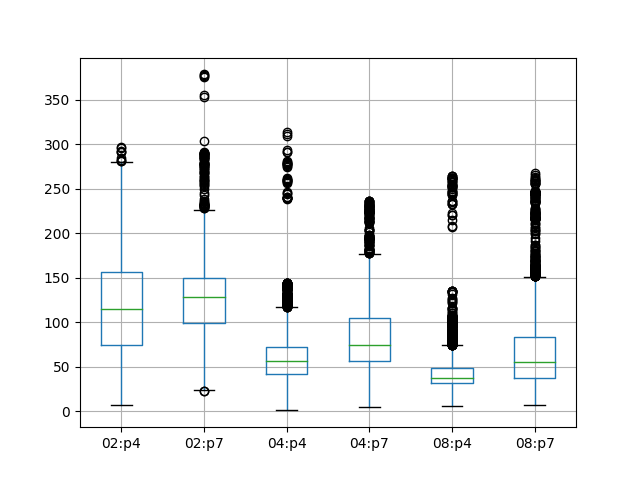

In [ ]:
start_index = 1000
stop_index = 8000
total_arm_length = 620

df_mocap_clean = df_mocap_shifted
df_rigid_clean = df_rigid_space
df_pcc1_clean = df_pcc1_timed
df_pcc2_clean = df_pcc2_timed
df_pcc4_clean = df_pcc4_timed
df_pcc6_clean = df_pcc6_timed
df_pcc8_clean = df_pcc8_timed
df_less_imu_2_clean = df_less_imu_2_timed
df_less_imu_4_clean = df_less_imu_4_timed 
df_less_imu_8_clean = df_pcc1_clean #df_less_imu_8_timed 
df_pcc16_2_clean = df_pcc16_2_timed
df_pcc16_4_clean = df_pcc16_4_timed
df_pcc16_8_clean = df_pcc2_timed #NOT 100%legit
axis_along_error = ['x','y','z']

df_err_rigid = norm_3D(err_wrt_mocap(df_mocap_clean, df_rigid_clean, start_index, stop_index), axis_along_error)
df_err_pcc1 = norm_3D(err_wrt_mocap(df_mocap_clean,df_pcc1_clean, start_index, stop_index), axis_along_error)
df_err_pcc2 = norm_3D(err_wrt_mocap(df_mocap_clean,df_pcc2_clean, start_index, stop_index), axis_along_error)
df_err_pcc4 = norm_3D(err_wrt_mocap(df_mocap_clean,df_pcc4_clean, start_index, stop_index), axis_along_error)
df_err_pcc6 = norm_3D(err_wrt_mocap(df_mocap_clean,df_pcc6_clean, start_index, stop_index), axis_along_error)
df_err_pcc8 = norm_3D(err_wrt_mocap(df_mocap_clean,df_pcc8_clean, start_index, stop_index), axis_along_error)
df_error_less_imu_2 = norm_3D(err_wrt_mocap(df_mocap_clean,df_less_imu_2_clean, start_index, stop_index), ['x','y','z'])
df_error_less_imu_4 = norm_3D(err_wrt_mocap(df_mocap_clean,df_less_imu_4_clean, start_index, stop_index), ['x','y','z'])
df_error_less_imu_8 = norm_3D(err_wrt_mocap(df_mocap_clean,df_less_imu_8_clean, start_index, stop_index), ['x','y','z'])
df_error_pcc16_2 = norm_3D(err_wrt_mocap(df_mocap_clean,df_pcc16_2_clean, start_index, stop_index), ['x','y','z'])
df_error_pcc16_4 = norm_3D(err_wrt_mocap(df_mocap_clean,df_pcc16_4_clean, start_index, stop_index), ['x','y','z'])
df_error_pcc16_8 = norm_3D(err_wrt_mocap(df_mocap_clean,df_pcc16_8_clean, start_index, stop_index), ['x','y','z'])

df_err_pcc1.columns = df_err_pcc1.columns.map(lambda x: '08:p'+x[4])
df_err_pcc2.columns = df_err_pcc2.columns.map(lambda x: '16:p'+x[4])
df_err_pcc4.columns = df_err_pcc4.columns.map(lambda x: '32:p'+x[4])
df_err_pcc6.columns = df_err_pcc6.columns.map(lambda x: '48s:p'+x[4])
df_err_pcc8.columns = df_err_pcc8.columns.map(lambda x: '64:p'+x[4])
df_error_less_imu_2.columns = df_error_less_imu_2.columns.map(lambda x: '02:p'+x[4])
df_error_less_imu_4.columns = df_error_less_imu_4.columns.map(lambda x: '04:p'+x[4])
df_error_less_imu_8.columns = df_error_less_imu_8.columns.map(lambda x: '08:p'+x[4])
df_error_pcc16_2.columns = df_error_pcc16_2.columns.map(lambda x: '02:p'+x[4])
df_error_pcc16_4.columns = df_error_pcc16_4.columns.map(lambda x: '04:p'+x[4])
df_error_pcc16_8.columns = df_error_pcc16_8.columns.map(lambda x: '08:p'+x[4])


df_err = df_error_less_imu_2.append([df_error_less_imu_4, df_err_pcc1,df_err_pcc2,df_err_pcc4,df_err_pcc6,df_err_pcc8])
df_err_2 = df_err_pcc1.append([df_err_pcc2,df_err_pcc4,df_err_pcc6,df_err_pcc8])
df_err_3 = df_error_pcc16_2.append([df_error_pcc16_4,df_error_pcc16_8])

col7, col4 = {}, {}

for col in df_err.columns:
    if 'p7' in col:
        col7[col] = str(int(col[0:2]))
    if 'p4' in col:
        col4[col] = str(int(col[0:2]))

df_err_7 = df_err[col7.keys()].rename(columns=col7)
df_err_4 = df_err[col4.keys()].rename(columns=col4)

df_err_rel_7 = df_err_7.apply(lambda x: x*100/582)
df_err_rel_4 = df_err_4.apply(lambda x: x*100/342)


#TODO #7
%matplotlib
df_err_3.boxplot()

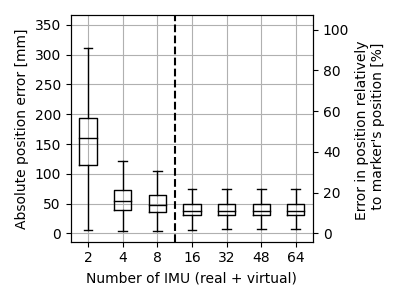

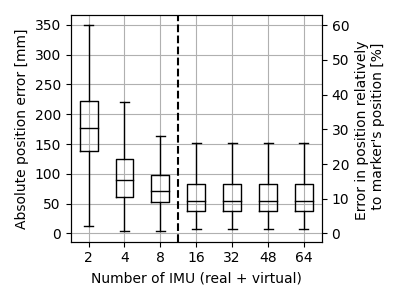

In [ ]:
%matplotlib widget
df_err_7.boxplot(showfliers=False, color='k')
my_ylim_abs = plt.ylim()
plt.clf()
plt.plot(df_err_rel_7.median())
my_ylim_med7 = plt.ylim()
plt.clf()
plt.plot(df_err_rel_4.median())
my_ylim_med4 = plt.ylim()
plt.clf()

L4, L7 = 3.42, 5.82

%matplotlib widget
fig, ax1 = plt.subplots(figsize=(4,3))
df_err_4.boxplot(showfliers=False, color='k', ax=ax1)
ax2 = ax1.twinx()
ax1.set_ylabel('Absolute position error [mm]')
ax1.set_ylim(np.array(my_ylim_abs))
ax2.set_ylim(np.array(my_ylim_abs)/L4)
ax2.set_ylabel('Error in position relatively \n to marker\'s position [%]')
ax1.set_xlabel('Number of IMU (real + virtual)')
plt.axvline(x=3.5, color='k', linestyle='--')

fig.tight_layout()

fig, ax1 = plt.subplots(figsize=(4,3))
df_err_7.boxplot(showfliers=False, color='k', ax=ax1)
ax2 = ax1.twinx()
ax1.set_ylabel('Absolute position error [mm]')
ax1.set_ylim(np.array(my_ylim_abs))
ax2.set_ylim(np.array(my_ylim_abs)/L7)
ax2.set_ylabel('Error in position relatively \n to marker\'s position [%]')
ax1.set_xlabel('Number of IMU (real + virtual)')
plt.axvline(x=3.5, color='k', linestyle='--')
fig.tight_layout()


if 0:
    %matplotlib widget
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_ylabel('Error in position w.r.t the motion capture [mm]')

    ax2.set_ylabel('Error in position relatively \n to mocap marker\'s position along the arm [%]')
    df_err_rel_7.boxplot(showfliers=False, color='k')

    ax1.plot(list(range(1,8)), df_err_7.median(), color='k', linewidth=3)

    ax1.set_ylim(my_ylim)
    ax1.set_xlabel('Number of segments')

Text(0.5, 0, 'Number of sub-segments for each marker')

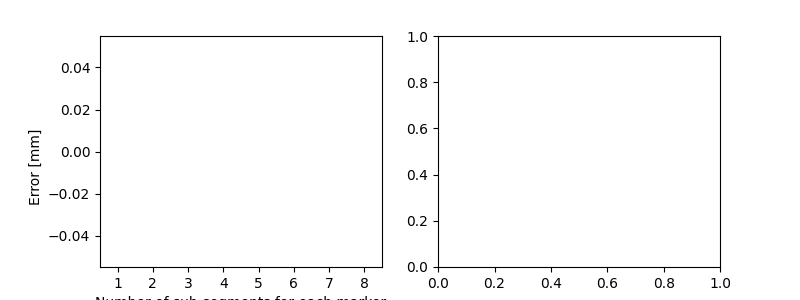

In [ ]:
%matplotlib widget
df_err_2_to_plot = df_err_2.rename(columns={'08:p4':8,'16:p4':16,'32:p4':32,'64:p4':64,'08:p7':'8','16:p7':'16','32:p7':'32','64:p7':'64'})

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

bplot = ax1.boxplot(df_err_2_to_plot[[8,16,32,64,'8','16','32','64']],showfliers=False, patch_artist=True)  # fill with color)

colors = ['pink', 'lightgreen']

#for patch, color in zip(bplot['boxes'], colors):
 #   patch.set_facecolor(color)

#ax1.axvline(x=4.5, color='k', linestyle='--')
ax1.set_ylabel('Error [mm]       ')
ax1.set_xlabel('Number of sub-segments for each marker')

#*.tight_layout()


<AxesSubplot:>

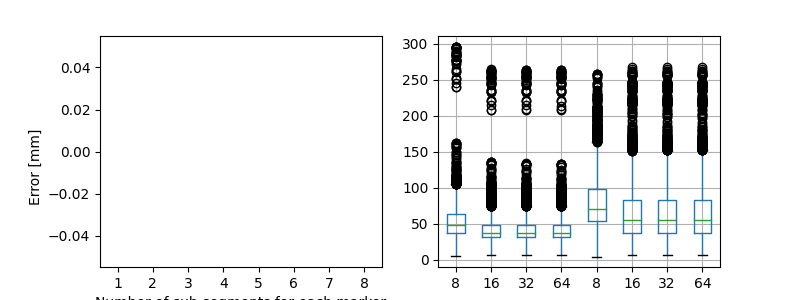

In [ ]:
df_err_2_to_plot[[8,16,32,64,'8','16','32','64']].boxplot()

Text(0.5, 1.0, 'Rectangular box plot')

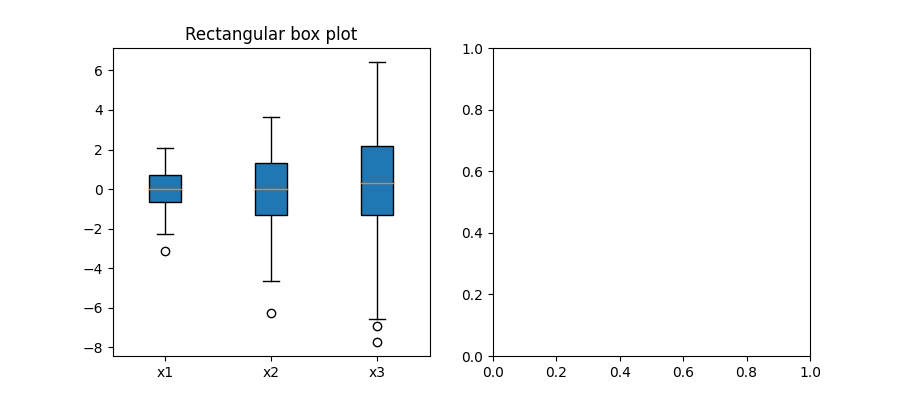

In [ ]:
np.random.seed(19680801)
all_data = [np.random.normal(0, std, size=100) for std in range(1, 4)]
labels = ['x1', 'x2', 'x3']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Rectangular box plot')


In [ ]:

# notch shape box plot
bplot2 = ax2.boxplot(all_data,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Three separate samples')
    ax.set_ylabel('Observed values')

plt.show()

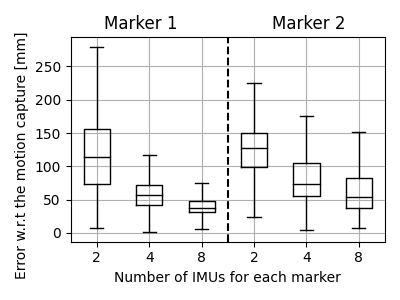

In [ ]:
#Plot for 16 sub-segments, and 2, 4, 8 IMUs

%matplotlib widget
plt.figure(figsize=(4,3))

df_err_3[['02:p4','04:p4','08:p4','02:p7','04:p7','08:p7']].rename(columns={'02:p4':2,'04:p4':4,'08:p4':8,'02:p7':'2','04:p7':'4','08:p7':'8'} ).boxplot(showfliers=False, color='k' )
plt.axvline(x=3.5, color='k', linestyle='--')
plt.ylabel('Error w.r.t the motion capture [mm]       ')
plt.title('Marker 1                  Marker 2 ')
plt.xlabel('Number of IMUs for each marker')
plt.tight_layout()


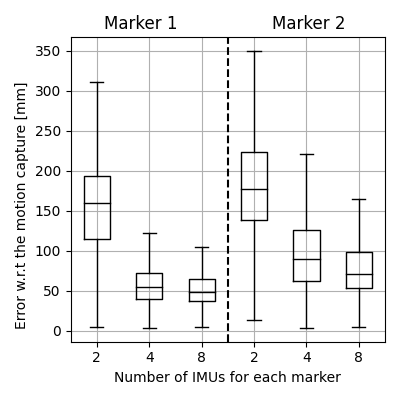

In [ ]:
df_err_less_imu = df_error_less_imu_2.append([df_error_less_imu_4,df_error_less_imu_8])



%matplotlib widget
plt.figure(figsize=(4,4))

df_err_less_imu[['02:p4','04:p4','08:p4','02:p7','04:p7','08:p7']].rename(columns={'02:p4':2,'04:p4':4,'08:p4':8,'02:p7':'2','04:p7':'4','08:p7':'8'}).boxplot(showfliers=False, color='k' )
plt.axvline(x=3.5, color='k', linestyle='--')
plt.ylabel('Error w.r.t the motion capture [mm]       ')
plt.title('Marker 1                  Marker 2 ')
plt.xlabel('Number of IMUs for each marker')
plt.tight_layout()


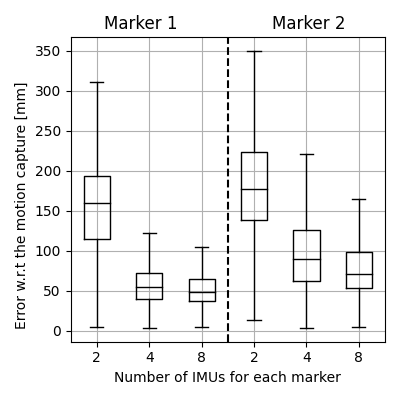

In [ ]:
df_err_less_imu = df_error_less_imu_2.append([df_error_less_imu_4,df_error_less_imu_8])



%matplotlib widget
plt.figure(figsize=(4,4))

df_err_less_imu = df_err_less_imu[['02:p4','04:p4','08:p4','02:p7','04:p7','08:p7']].rename(columns={'02:p4':2,'04:p4':4,'08:p4':8,'02:p7':'2','04:p7':'4','08:p7':'8'} )
df_err_less_imu.boxplot(showfliers=False, color='k' )
plt.axvline(x=3.5, color='k', linestyle='--')
plt.ylabel('Error w.r.t the motion capture [mm]       ')
plt.title('Marker 1                  Marker 2 ')
plt.xlabel('Number of IMUs for each marker')
plt.tight_layout()


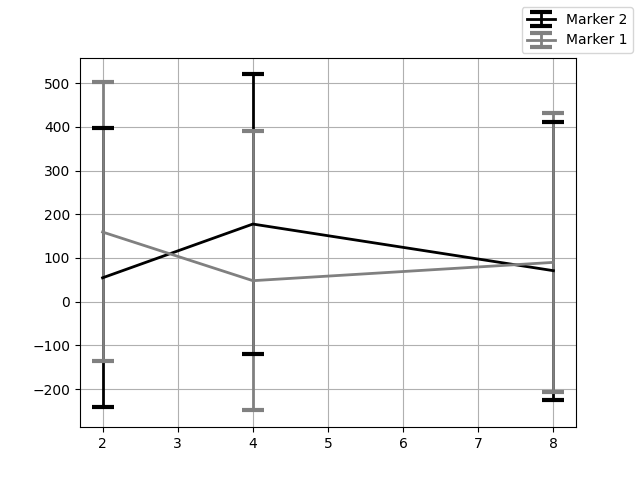

In [ ]:
%matplotlib widget 
fig = plt.figure()
med_err = np.array(df_err_less_imu.median())
quart1 = np.array(df_err_less_imu.quantile(q=0.1, axis=1))
quart3 = np.array(df_err_less_imu.quantile(q=0.9, axis=1))
med_err_4 = med_err[[0,2,4]]
med_err_7 = med_err[[1,3,5]]
quart1_4 = quart1[[0,2,4]]
quart1_7 = quart1[[1,3,5]]
quart3_4 = quart3[[0,2,4]]
quart3_7 = quart3[[1,3,5]]
plt.errorbar(x=np.array([2,4,8]), y=med_err_7, yerr=(quart1_7,quart3_7), color='k', capsize=8, capthick=3, linewidth=2)
plt.errorbar(x=np.array([2,4,8]), y=med_err_4, yerr=(quart1_4,quart3_4), color='grey', capsize=8, capthick=3, linewidth=2)
fig.legend(['Marker 2', 'Marker 1' ], loc='upper right' )
#plt.plot(med_err_7)
plt.grid(1)


Text(0, 0.5, 'Speed (m/s)')

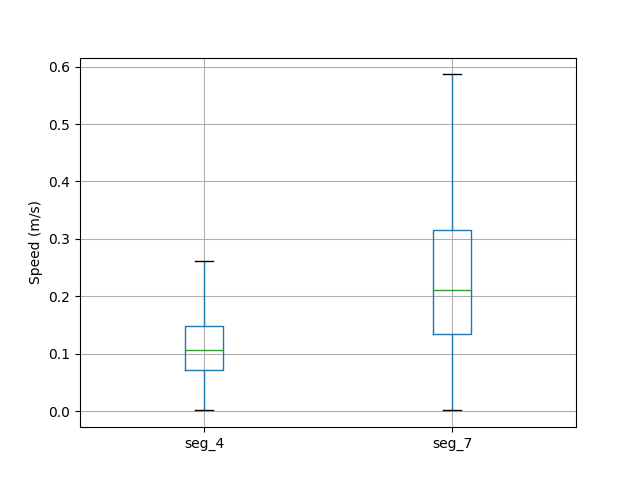

In [ ]:
# Compute average speed for each segment
%matplotlib widget
period_ms = 30
(norm_3D(df_mocap_clean.diff().rolling(window=5).mean())/period_ms).boxplot(showfliers=0) #milliseconds per millimeters
plt.ylabel('Speed (m/s)')



In [ ]:


df_error_pcc16_8

df_error_less_imu_8.quantile(0.75)






08:p4    63.852491
08:p7    97.579998
Name: 0.75, dtype: float64